In [1]:
import numpy as np
import tempfile, sys, os
import numpy as np
from scipy.misc import imread
import tensorflow as tf
from deepexplain.tensorflow import DeepExplain
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

config = tf.ConfigProto(
    device_count = {'GPU': 0}
)
config.gpu_options.allocator_type = 'BFC'


def load_graph(model_file):
    graph = tf.Graph()
    graph_def = tf.GraphDef()
    with open(model_file, "rb") as f:
        graph_def.ParseFromString(f.read())
    with graph.as_default():
        tf.import_graph_def(graph_def)

    return graph


def read_tensor_from_image_file(file_name,
                                input_height=299,
                                input_width=299,
                                input_mean=0,
                                input_std=255):
    input_name = "file_reader"
    output_name = "normalized"
    file_reader = tf.read_file(file_name, input_name)
    if file_name.endswith(".png"):
        image_reader = tf.image.decode_png(
            file_reader, channels=3, name="png_reader")
    elif file_name.endswith(".gif"):
        image_reader = tf.squeeze(
            tf.image.decode_gif(file_reader, name="gif_reader"))
    elif file_name.endswith(".bmp"):
        image_reader = tf.image.decode_bmp(file_reader, name="bmp_reader")
    else:
        image_reader = tf.image.decode_jpeg(
            file_reader, channels=3, name="jpeg_reader")
    float_caster = tf.cast(image_reader, tf.float32)
    dims_expander = tf.expand_dims(float_caster, 0)
    resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
    normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
    sess = tf.Session(config=config)
    result = sess.run(normalized)

    return result


def load_labels(label_file):
    label = []
    proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
    for l in proto_as_ascii_lines:
        label.append(l.rstrip())
    return label

## file_name = "/Z/personal-folders/interns/saket/histopath_data/baidu_images/training/tumor/tumor_100_60249_38668_256.jpg"
model_file = "/Z/personal-folders/interns/saket/resnetv2_retrain_model_camelyon16_200000_alldata_100k/retrained_graph.pb"
label_file = "/Z/personal-folders/interns/saket/resnetv2_retrain_model_camelyon16_200000_alldata_100k/retrained_labels.txt"
input_height = 299
input_width = 299
input_mean = 0
input_std = 255
input_layer = "Placeholder"
output_layer = "final_result"



graph = load_graph(model_file)
t = read_tensor_from_image_file(
  file_name,
  input_height=input_height,
  input_width=input_width,
  input_mean=input_mean,
  input_std=input_std)

input_name = "import/" + input_layer
output_name = "import/" + output_layer
input_operation = graph.get_operation_by_name(input_name)
output_operation = graph.get_operation_by_name(output_name)

with tf.Session(graph=graph, config=config) as sess:
    results = sess.run(output_operation.outputs[0], {
        input_operation.outputs[0]: t
    })
results = np.squeeze(results)

top_k = results.argsort()[-5:][::-1]
labels = load_labels(label_file)
for i in top_k:
    print(labels[i], results[i])

In [13]:
xs = np.array([1])
tf.reset_default_graph()
# Since we will explain it, the model has to be wrapped in a DeepExplain context
with tf.Session(graph=graph, config=config) as sess:
    with DeepExplain(session=sess, graph=sess.graph) as de:
        results = sess.run(output_operation.outputs[0], {
            input_operation.outputs[0]: t
        })
        #X = t
        logits = np.squeeze(results)
        
        top_k = logits.argsort()[-5:][::-1]
        labels = load_labels(label_file)
        
with tf.Session(graph=graph, config=config) as sess:
    t = read_tensor_from_image_file(
        file_name,
        input_height=input_height,
        input_width=input_width,
        input_mean=input_mean,
        input_std=input_std)
    input_name = "import/" + input_layer
    output_name = "import/" + output_layer
    input_operation = graph.get_operation_by_name(input_name)
    output_operation = graph.get_operation_by_name(output_name)

    with DeepExplain(session=sess, graph=sess.graph) as de:       
        #X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

        #explain(method_name, target_tensor, input_tensor, samples, ...args)
        attributions = {
            # Gradient-based
        # NOTE: reduce_max is used to select the output unit for the class predicted by the classifier
        # For an example of how to use the ground-truth labels instead, see mnist_cnn_keras notebook

        'Saliency maps':        de.explain('saliency', output_operation.outputs[0]* [0, 1], 
                                           input_operation.outputs[0], 
                                           t),
        'DeepLIFT (Rescale)':   de.explain('deeplift', output_operation.outputs[0] * [0, 1], input_operation.outputs[0], t),
        'Gradient * Input':     de.explain('grad*input', output_operation.outputs[0]* [0, 1], input_operation.outputs[0], t),
        'Integrated Gradients': de.explain('intgrad', output_operation.outputs[0]* [0, 1], input_operation.outputs[0], t),
        'Epsilon-LRP':          de.explain('elrp', output_operation.outputs[0]* [0, 1], input_operation.outputs[0], t),

        # Perturbation-based (comment out to evaluate, but this will take a while!)
        # 'Occlusion [15x15]':    de.explain('occlusion', tf.reduce_max(logits, 1), X, xs, window_shape=(15,15,3), step=4)
    }
    print ("Done!")


DeepExplain: running "saliency" explanation method (1)
Model with multiple inputs:  False
DeepExplain: running "deeplift" explanation method (5)
Model with multiple inputs:  False


/Z/personal-folders/interns/saket/src/deepexplain/deepexplain/tensorflow/methods.py:459: UserWarning: DeepExplain detected you are trying to use an attribution method that requires gradient override but the original gradient was used instead. You might have forgot to (re)create your graph within the DeepExlain context. Results are not reliable!
  warnings.warn('DeepExplain detected you are trying to use an attribution method that requires '


DeepExplain: running "grad*input" explanation method (2)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "elrp" explanation method (4)
Model with multiple inputs:  False
Done!


In [12]:
output_operation.outputs[0] * [0, 1]

<tf.Tensor 'mul_3:0' shape=(?, 2) dtype=float32>

/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


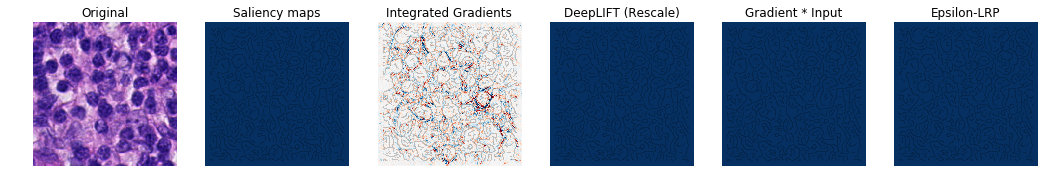

In [10]:
from utils import plot, plt
%matplotlib inline
xs = t
attributions_reduced = attributions
#attributions_reduced['Integrated Gradients'] = attributions['Integrated Gradients']
n_cols = int(len(attributions_reduced)) + 1
n_rows = len(xs) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, xi in enumerate(xs):
    xi = (xi - np.min(xi))
    xi /= np.max(xi)
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original')
    ax.axis('off')
    for j, a in enumerate(attributions_reduced):
        axj = axes.flatten()[i*n_cols + j + 1]
        plot(attributions[a][i], xi = xi, axis=axj, dilation=.5, percentile=99, alpha=.2).set_title(a)